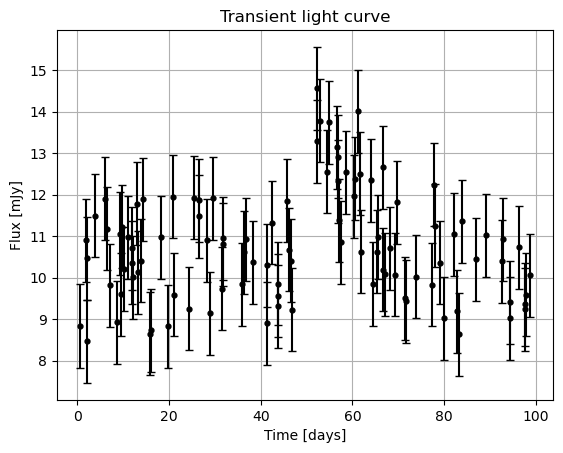

In [118]:
import numpy as np
from matplotlib import pyplot as plt
import dynesty 
import scipy.stats


data = np.load('transient.npy', allow_pickle=True)
time = data[:,0]
flux = data[:,1]
sigma = data[:,2]
fig1, ax1 = plt.subplots()
ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Flux [mJy]")
ax1.set_title("Transient light curve")
ax1.errorbar(time, flux, yerr=sigma, fmt='.k', markersize=7, capsize= 3, zorder = 2)
ax1.grid()


In [138]:
ndim = 4 # Number of parameters: b, t0, A, c

def model_burst(params, t):
    b, t0, A, c = params
    exponent = -c*(t - t0)
    exponent = np.clip(exponent, -100, 100)  # Prevent overflow
    f = A * np.exp(exponent)  
    return np.where(t < t0, b, b + f) 

def model_gauss(params, t):
    b, t0, A, sigmaw = params
    exponent = -0.5*((t - t0)/sigmaw)**2
    exponent = np.clip(exponent, -100, 100)  # Prevent overflow
    return b + A * np.exp(exponent)

def LogLikelihood (params, t, y, sigmay, model):
    flux_model = model(params, time)
    return -0.5*(np.log(2*np.pi) + np.sum(((y-flux_model)/sigmay)**2))

def Prior_burst (u):
    x_b = np.array(u) 
    x_b[0] = scipy.stats.uniform(loc=9,scale=2).ppf(u[0])
    x_b[1] = scipy.stats.uniform(loc=45, scale=10).ppf(u[1])
    x_b[2] = scipy.stats.uniform(loc=0, scale=15).ppf(u[2])
    x_b[3] = scipy.stats.loguniform.ppf(u[3], np.exp(-3), np.exp(-1.20))
    return x_b

def Prior_gauss (u):
    x_g = np.array(u) 
    x_g[0] = scipy.stats.uniform(loc=9,scale=2).ppf(u[0])
    x_g[1] = scipy.stats.uniform(loc=48, scale=15).ppf(u[1])
    x_g[2] = scipy.stats.uniform(loc=0, scale=10).ppf(u[2])
    x_g[3] = scipy.stats.loguniform.ppf(u[3], np.exp(0), np.exp(3))
    return x_g

In [139]:
sampler_burst = dynesty.NestedSampler(LogLikelihood, Prior_burst, ndim, logl_args=[time, flux, sigma, model_burst], nlive=300, sample='unif')
sampler_burst.run_nested()
results_burst = sampler_burst.results

2207it [01:55, 19.06it/s, +300 | bound: 17 | nc: 1 | ncall: 17945 | eff(%): 14.208 | loglstar:   -inf < -49.694 <    inf | logz: -55.785 +/-  0.131 | dlogz:  0.001 >  0.309]


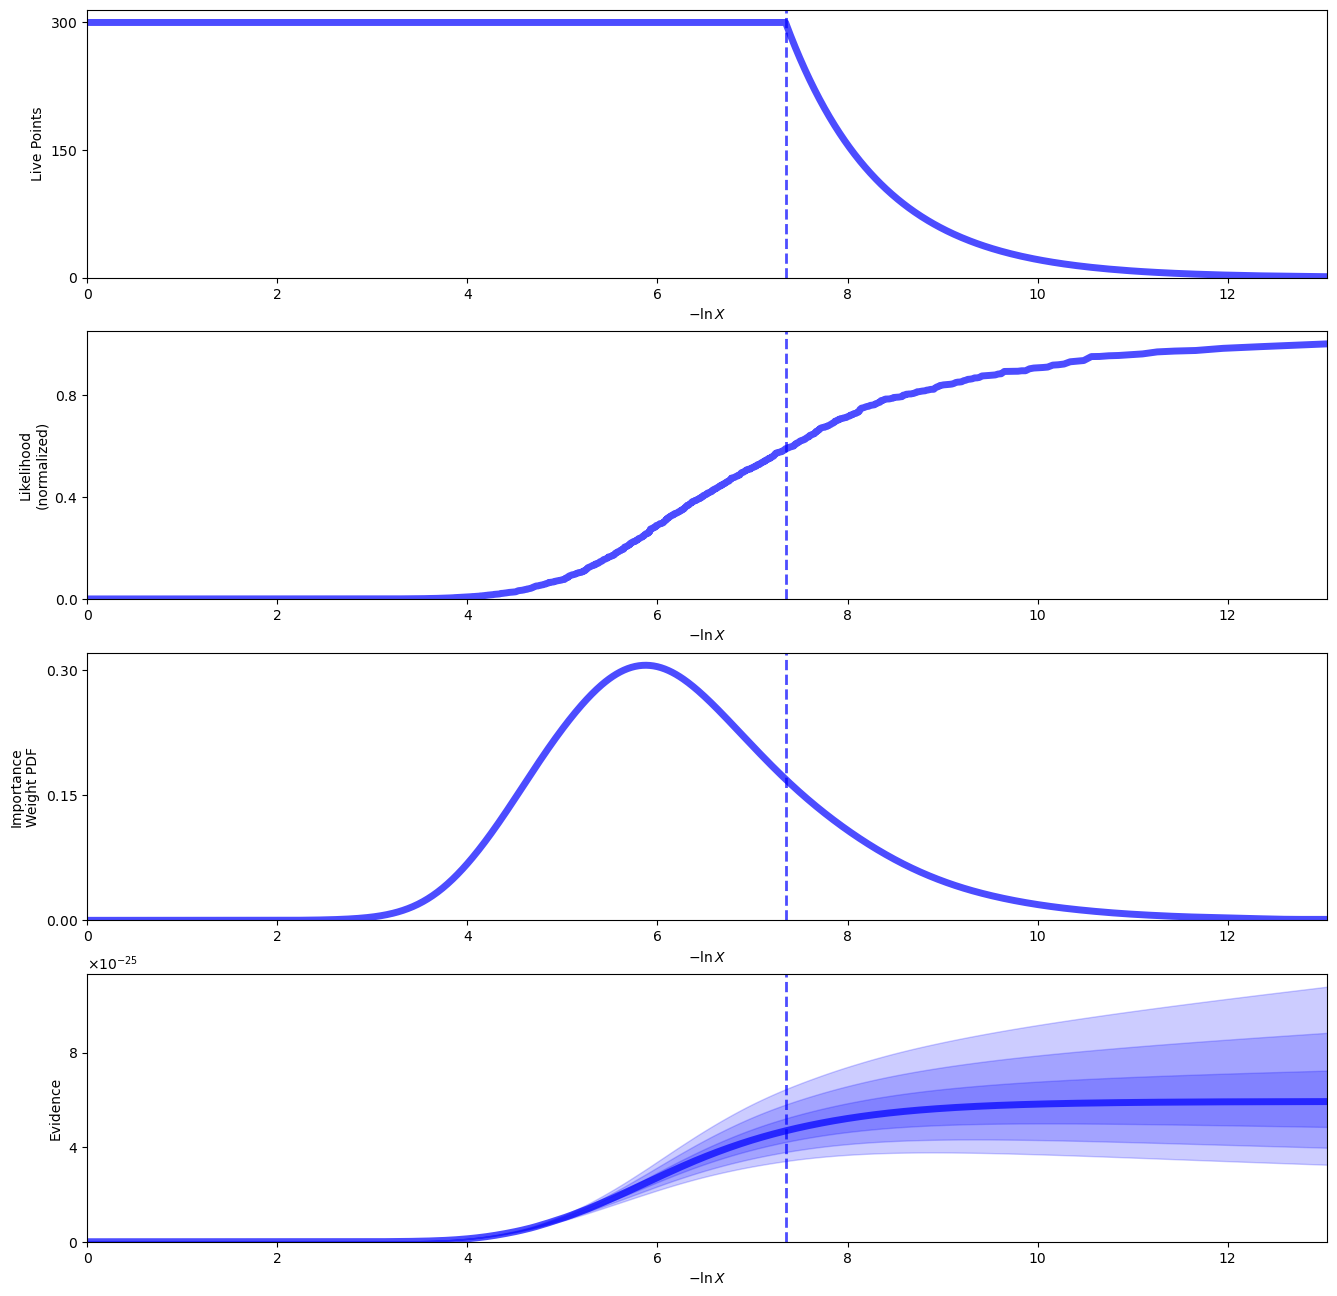

In [140]:
from dynesty import plotting as dyplot
fig2, ax2 = dyplot.runplot(results_burst)

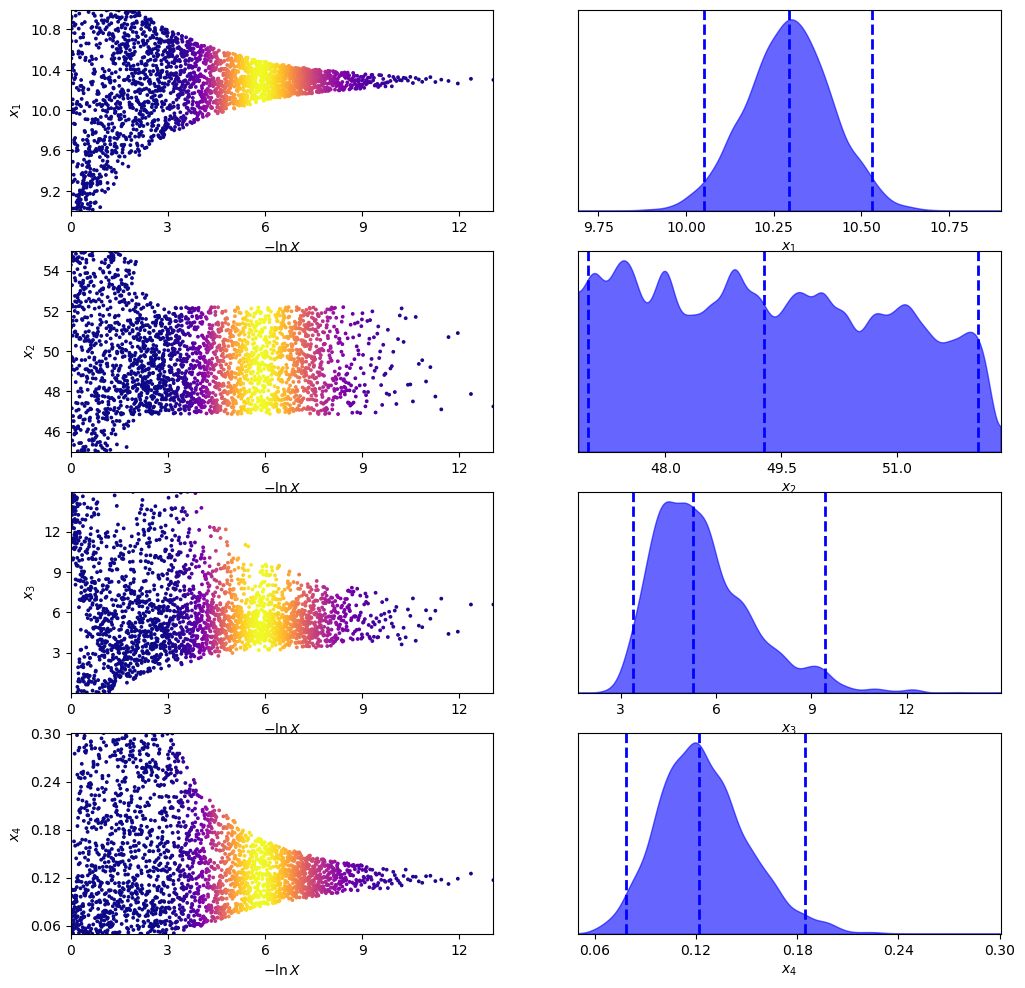

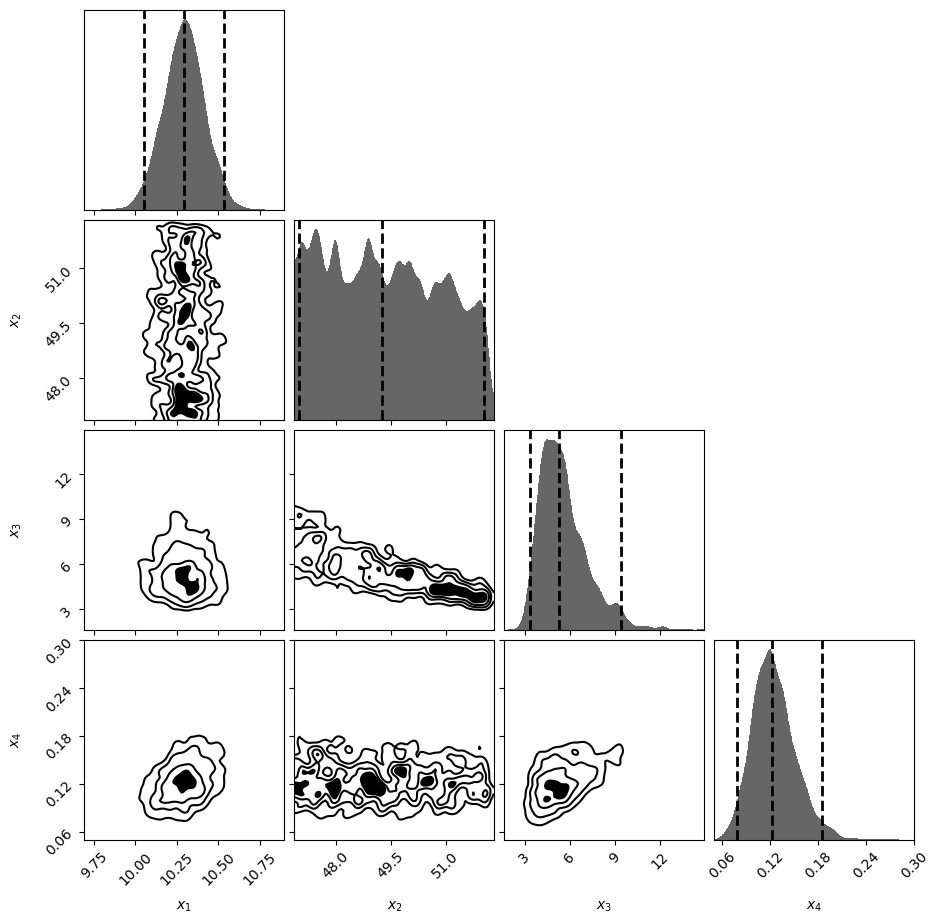

In [141]:
tfig2, taxes2 = dyplot.traceplot(results_burst)
cfig2, caxes2 = dyplot.cornerplot(results_burst)

In [142]:
from dynesty import utils as dyfunc
from dynesty.utils import resample_equal


# Extract sampling results.
samples_burst = results_burst.samples  # samples
weights_burst = np.exp(results_burst.logwt - results_burst.logz[-1])  # normalized weights

means_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, weights_burst)
print("Mean parameters and covariance", means_burst, cov_burst.diagonal())

dw = resample_equal(samples_burst, weights_burst)
medians_burst = np.median(dw, axis=0)
print("Median parameters", medians_burst)

def weighted_median(data, weights):
    idx = np.argsort(data)
    data, weights = data[idx], weights[idx]
    cumsum = np.cumsum(weights)
    return data[np.searchsorted(cumsum, 0.5 * np.sum(weights))]

w_medians_burst = np.array([weighted_median(samples_burst[:, i], weights_burst) for i in range(samples_burst.shape[1])])
print("Weighted median parameters", w_medians_burst)



Mean parameters and covariance [10.29312174 49.35591429  5.59623305  0.12466068] [1.49885642e-02 2.31900345e+00 2.54202165e+00 7.31774726e-04]
Median parameters [10.29511927 49.27378389  5.27349813  0.12180392]
Weighted median parameters [10.29358709 49.27378389  5.27980222  0.12201968]


In [135]:
sampler_gauss = dynesty.NestedSampler(LogLikelihood, Prior_gauss, ndim, logl_args=[time, flux, sigma, model_gauss], nlive=300, sample='unif')
sampler_gauss.run_nested()
results_gauss = sampler_gauss.results

2878it [01:33, 30.77it/s, +300 | bound: 12 | nc: 1 | ncall: 16453 | eff(%): 19.674 | loglstar:   -inf < -53.384 <    inf | logz: -61.738 +/-  0.158 | dlogz:  0.001 >  0.309]


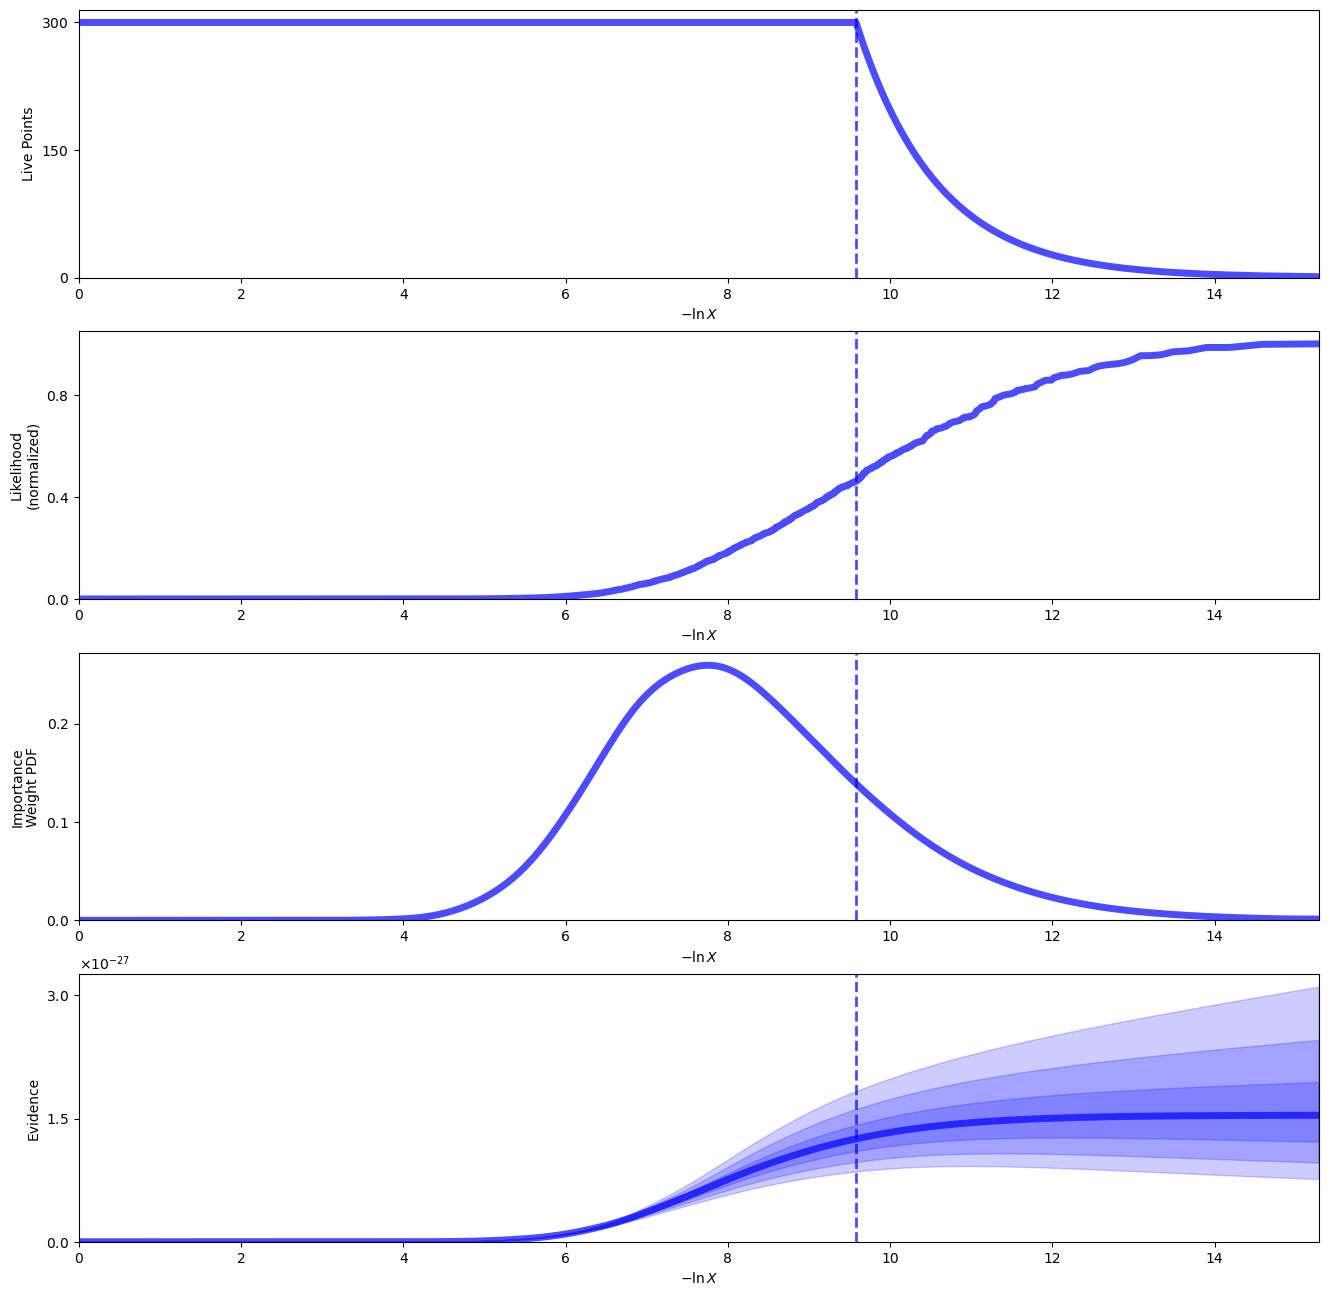

In [136]:
fig3, ax3 = dyplot.runplot(results_gauss)

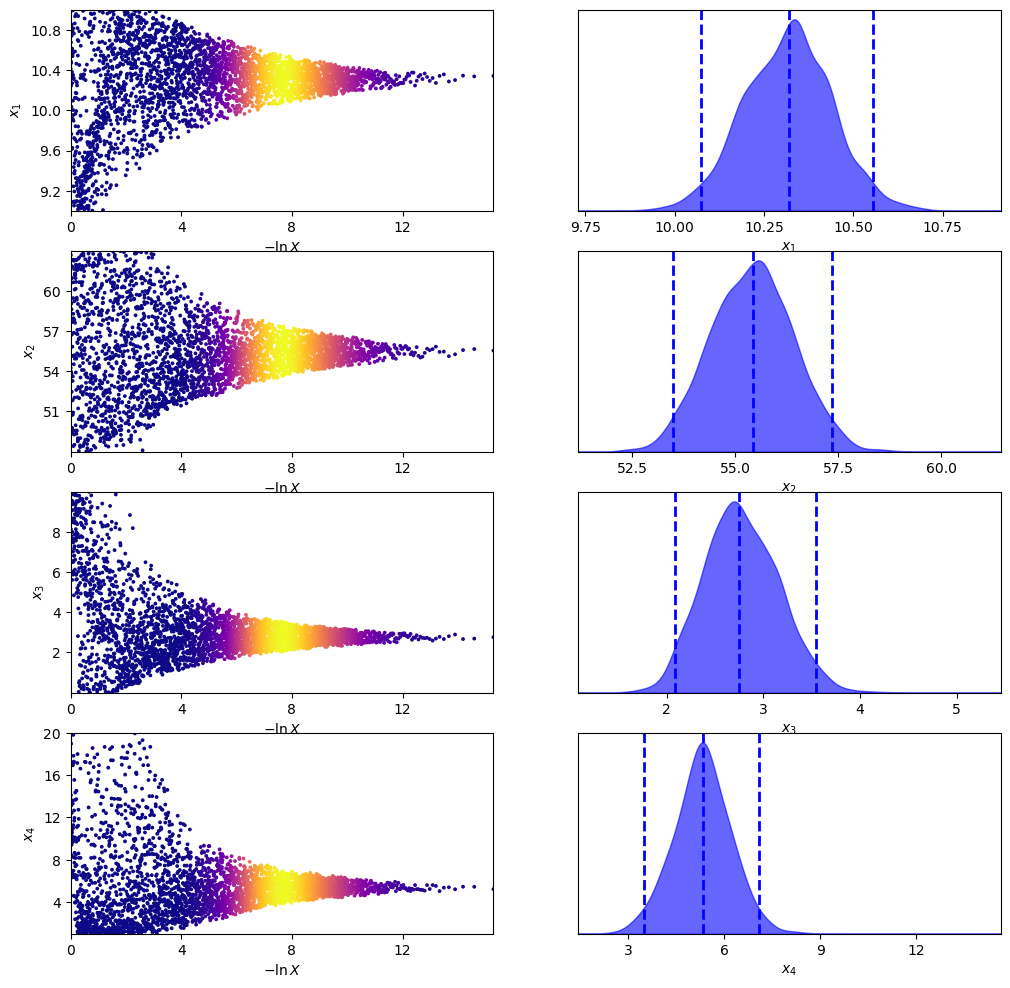

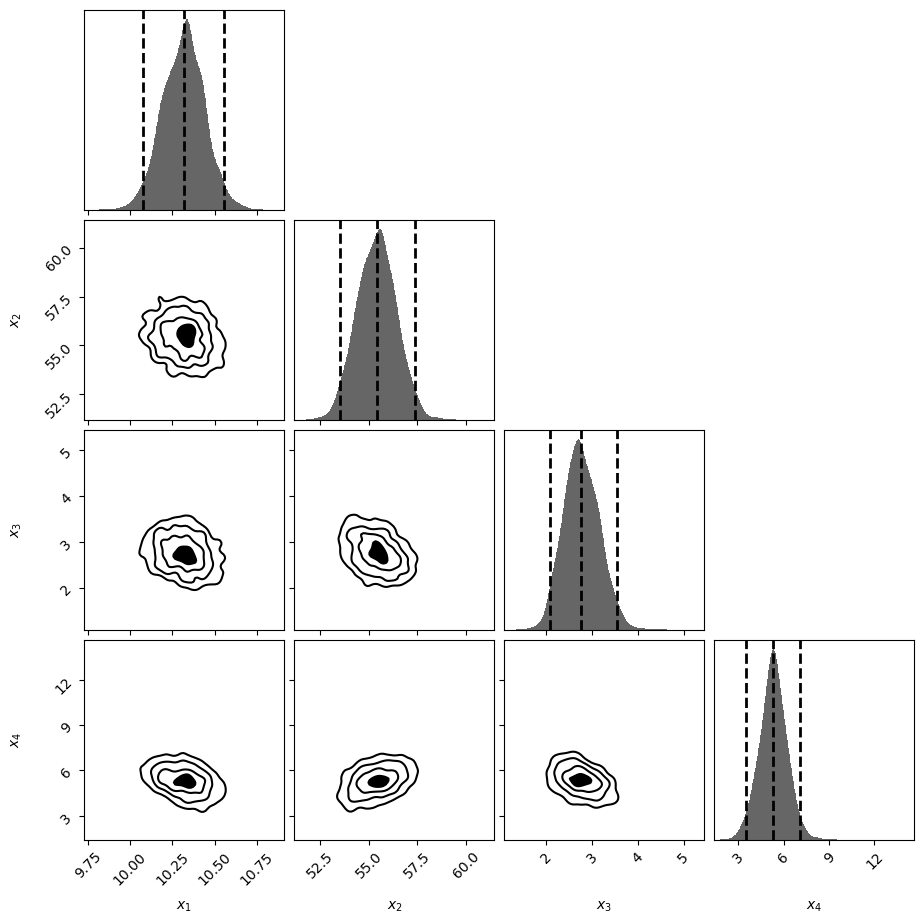

In [137]:
tfig3, taxes3 = dyplot.traceplot(results_gauss)
cfig3, caxes3 = dyplot.cornerplot(results_gauss)

In [144]:
evidence_burst = results_burst.logz[-1] #evidence for burst model
print("Bayesian evidence for burst model", np.exp(evidence_burst))

evidence_gauss = results_gauss.logz[-1] #evidence for gaussian model
print("Bayesian evidence for gauss model", np.exp(evidence_gauss))

print("Bayesian evidence ratio", np.exp(evidence_burst)/np.exp(evidence_gauss)) #ratio of evidences

Bayesian evidence for burst model 5.925573311841917e-25
Bayesian evidence for gauss model 1.540382042295044e-27
Bayesian evidence ratio 384.6820560835216
